In [8]:
from src.plot_utils import plot_scatter,plot_map
import os,glob,cmaps,sys
import hydroeval as he
import numpy as np
from pyogrio import read_dataframe
import pandas as pd
import pickle
import shap
import fasttreeshap
from src.myshap import createShapExplanation
import seaborn as sns
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
from scipy.stats import pearsonr
from matplotlib.colors import LogNorm
import matplotlib.font_manager as font_manager
font_manager.fontManager.addfont(os.environ['DATA']+'/fonts/Helvetica/Helvetica.ttf')
font_manager.fontManager.addfont(os.environ['DATA']+'/fonts/Helvetica/Helvetica-Bold.ttf')
plt.rc('font', size = 12, family = 'Helvetica')

model = 'rf'
df_Qmax7 = pd.read_csv(f'../results/{model}_cv10_Qmax7_raw_result_MSWX.csv')
df_Qmin7 = pd.read_csv(f'../results/{model}_cv10_Qmin7_raw_result_MSWX.csv')

palette = {'tropical':'#F8D347','dry':'#C7B18A','temperate':"#65C2A5",'cold':"#a692b0",'polar':"#B3B3B3"}

### plot PDF of the target variable

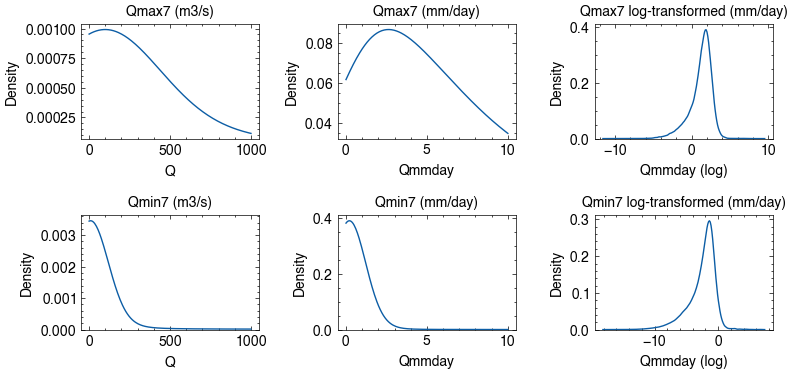

In [5]:
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
fig, axes = plt.subplots(2, 3, figsize=(8,4))
for i,name in enumerate(['Qmax7','Qmin7']):
    if name == 'Qmax7':
        df = df_Qmax7.copy()
    else:
        df = df_Qmin7.copy()
    df['Qmmday'] = df['Q'] / df['gritDarea'] * 86.4
    df['Qmmday (log)'] = np.log(df['Qmmday'])
    sns.kdeplot(df, x = 'Q', ax = axes[i,0], clip = [0, 1000])
    sns.kdeplot(df, x = 'Qmmday', ax = axes[i,1], clip = [0, 10])
    sns.kdeplot(df, x = 'Qmmday (log)', ax = axes[i,2])
    axes[i,0].set_title(f'{name} (m3/s)', fontsize = 10)
    axes[i,1].set_title(f'{name} (mm/day)', fontsize = 10)
    axes[i,2].set_title(f'{name} log-transformed (mm/day)', fontsize = 10)
fig.tight_layout()
fig.savefig('../picture/hist_Qmin7_Qmax7.png', dpi = 600)

### plot a map of the length of records

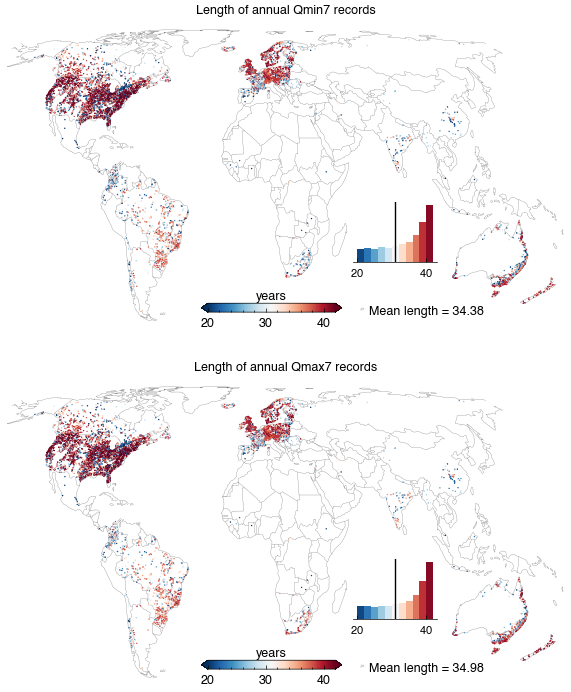

In [7]:
fig, axes = plt.subplots(2, 1, figsize = (8, 8.5), subplot_kw={'projection':ccrs.EqualEarth()})
for i,name in enumerate(['Qmin7','Qmax7']):
    if i == 0:
        df = df_Qmin7.copy()
        ax = axes[0]
    else:
        df = df_Qmax7.copy()
        ax = axes[1]
    df_sta = df.groupby(['ohdb_id','ohdb_longitude','ohdb_latitude','climate_label'])['dam'].count().reset_index()
    lons = df_sta.ohdb_longitude.values
    lats = df_sta.ohdb_latitude.values
    vals = df_sta['dam'].values
    vmin = 20
    vmax = 42
    vind = 2
    cmap = 'RdBu_r'
    title = f'Length of annual {name} records'
    label = 'years'
    plot_map(ax, lons, lats, vals, vmin, vmax, vind, cmap, title, label, size = 1, fontSize = 9, norm = None)
    ave0 = df_sta.dam.mean()
    ax.text(.75, .05, 'Mean length = %.2f'%ave0, transform = ax.transAxes, ha = 'center', va = 'top', fontsize = 9)
fig.savefig(f'../picture/length_of_records.png', dpi = 600)

### plot scatterplot

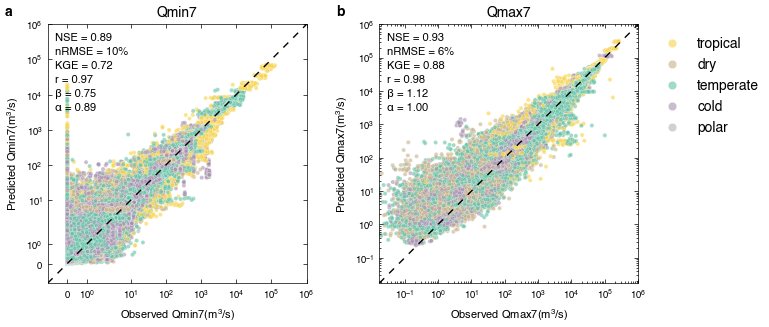

In [9]:
fig, axes = plt.subplots(1, 2, figsize = (8, 4))
plot_scatter(df_Qmin7.Q.values, 
            df_Qmin7['pred'].values, 
            df_Qmin7.climate_label.values, 
            'Observed Qmin7' + '($\mathregular{m^3/s}$)', 
            'Predicted Qmin7' +  '($\mathregular{m^3/s}$)', 
            normColor = 'norm',
            palette = palette,
            fontsize = 8,
            legend = False,
            ax = axes[0])
axes[0].set_title('Qmin7', fontsize = 10)
plot_scatter(df_Qmax7.Q.values, 
            df_Qmax7['pred'].values, 
            df_Qmax7.climate_label.values, 
            'Observed Qmax7' + '($\mathregular{m^3/s}$)', 
            'Predicted Qmax7' +  '($\mathregular{m^3/s}$)', 
            normColor = 'norm',
            palette = palette,
            fontsize = 8,
            ax = axes[1])
sns.move_legend(axes[1], 'upper left', bbox_to_anchor = (1.03, 1), markerscale = 2, fontsize = 10)
axes[1].set_title('Qmax7', fontsize = 10)
axes[0].text(-.15, 1.05, 'a', weight = 'bold', ha = 'center', va = 'center', fontsize = 10, transform = axes[0].transAxes)
axes[1].text(-.15, 1.05, 'b', weight = 'bold', ha = 'center', va = 'center', fontsize = 10, transform = axes[1].transAxes)
axes[0].set_xlim(-1, 1e6)
axes[0].set_ylim(-1, 1e6)
axes[1].set_xlim(-1, 1e6)
axes[1].set_ylim(-1, 1e6)
fig.tight_layout()
fig.savefig(f'../picture/scatter_cv10_{model}_multi_meteo_MSWX.png', dpi = 600)

### maps of KGE 

0.5304656153774377
0.8657273490715686


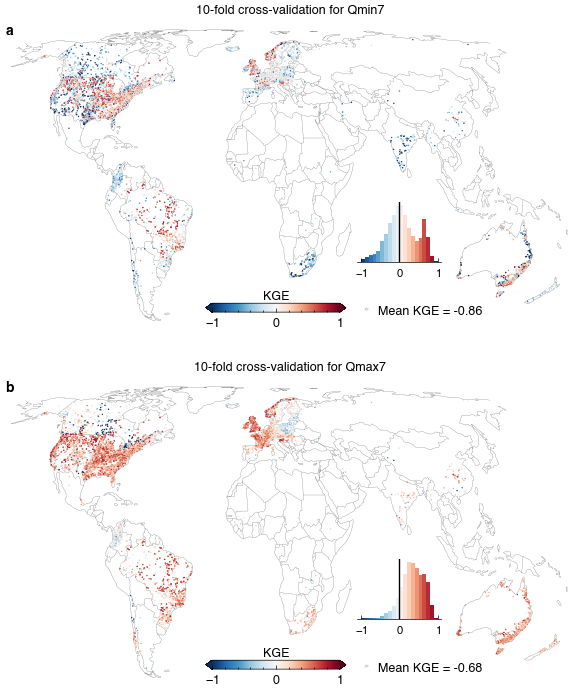

In [10]:
fig, axes = plt.subplots(2, 1, figsize = (8, 8.5), subplot_kw={'projection':ccrs.EqualEarth()})
for i,name in enumerate(['Qmin7','Qmax7']):
    if i == 0:
        df = df_Qmin7.copy()
        ax = axes[0]
    else:
        df = df_Qmax7.copy()
        ax = axes[1]
    df_sta = df.groupby(['ohdb_id','ohdb_latitude', 'ohdb_longitude','climate_label']).apply(
        lambda x: pd.Series(
            he.kge(x.pred.values, x.Q.values).squeeze(), index = ['KGE','r','alpha','beta'])
    ).reset_index()
    print(df_sta.loc[df_sta.KGE>0,:].shape[0]/df_sta.shape[0])
    lons = df_sta.ohdb_longitude.values
    lats = df_sta.ohdb_latitude.values
    vals = df_sta['KGE'].values
    vmin = -1
    vmax = 1
    vind = .1
    cmap = 'RdBu_r'
    title = f'10-fold cross-validation for {name}'
    label = 'KGE'
    plot_map(ax, lons, lats, vals, vmin, vmax, vind, cmap, title, label, size = 1, fontSize = 9, norm = None)
    ave0 = df_sta.KGE.mean()
    ax.text(.75, .05, 'Mean KGE = %.2f'%ave0, transform = ax.transAxes, ha = 'center', va = 'top', fontsize = 9)
    ax.text(0, 1, ['a','b'][i], transform = ax.transAxes, ha = 'center', va = 'top', fontsize = 10, weight = 'bold')
fig.savefig(f'../picture/map_kge_cv10_{model}_multi_meteo_MSWX.png', dpi = 600)

### plot the sensitivity of model performance to length of records

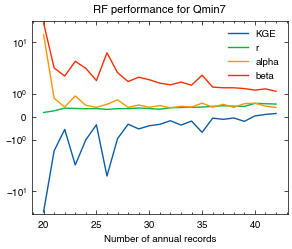

In [16]:
df = df_Qmin7.copy()
df_sta = df.groupby(['ohdb_id','ohdb_latitude', 'ohdb_longitude','climate_label']).apply(
        lambda x: pd.Series(
            he.kge(x.pred.values, x.Q.values).squeeze().tolist()+[x.shape[0]], index = ['KGE','r','alpha','beta','Number of annual records'])
    ).reset_index()
df_sta.groupby('Number of annual records')[['KGE','r','alpha','beta']].mean().plot()
plt.yscale('symlog')
plt.title('RF performance for Qmin7', fontsize = 8)
plt.savefig(f'../picture/{model}_Qmin7_performance_across_different_records.png', dpi = 600)

### maps of nRMSE

0.10273397405990482
0.03947000093309695


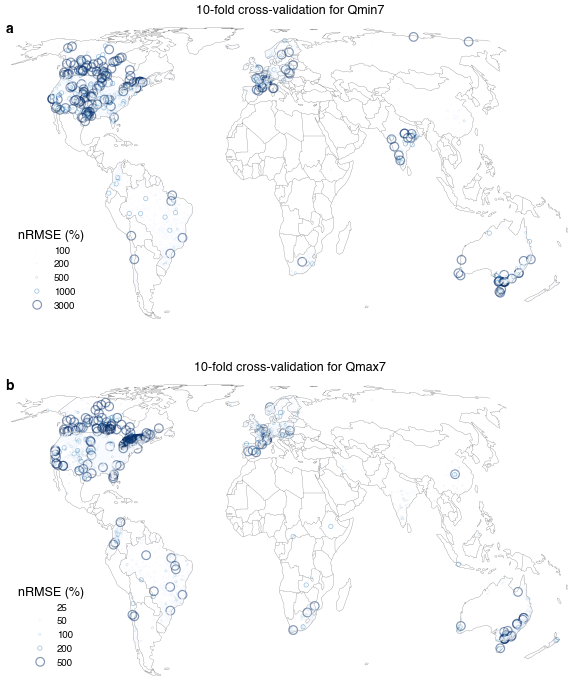

In [4]:
fig, axes = plt.subplots(2, 1, figsize = (8, 8.5), subplot_kw={'projection':ccrs.EqualEarth()})
for i,name in enumerate(['Qmin7','Qmax7']):
    if i == 0:
        df = df_Qmin7.copy()
        ax = axes[0]
    else:
        df = df_Qmax7.copy()
        ax = axes[1]
    df_sta = df.groupby(['ohdb_id','ohdb_latitude', 'ohdb_longitude','climate_label']).apply(
        lambda x: pd.Series(
            [np.sum((x.pred.values-x.Q.values)**2) / np.sum(x.Q.values**2) * 100], index = ['nRMSE'])
    ).reset_index()
    print(df_sta.loc[df_sta.nRMSE>100,:].shape[0]/df_sta.shape[0])
    title = f'10-fold cross-validation for {name}'
    label = 'nRMSE (%)'
    size_norm = mpl.colors.BoundaryNorm([0, 50, 80, 100, 150, 200], clip = True, ncolors = 5)
    size_norm = mpl.colors.LogNorm()
    df_sta.loc[df_sta.nRMSE>5000,'nRMSE'] = 5000
    df_sta.loc[df_sta.nRMSE<1,'nRMSE'] = 1
    if i == 0:
        df_sta['nRMSE1'] = 100
        df_sta.loc[(df_sta.nRMSE>200)&(df_sta.nRMSE<=500),'nRMSE1'] = 200
        df_sta.loc[(df_sta.nRMSE>500)&(df_sta.nRMSE<=1000),'nRMSE1'] = 500
        df_sta.loc[(df_sta.nRMSE>1000)&(df_sta.nRMSE<=3000),'nRMSE1'] = 1000
        df_sta.loc[(df_sta.nRMSE>3000),'nRMSE1'] = 3000
        sns.scatterplot(df_sta, x = 'ohdb_longitude', y = 'ohdb_latitude', hue = 'nRMSE1', size = 'nRMSE1', hue_norm = size_norm, palette = 'Blues',
                    marker = "$\circ$", ec = "face", alpha = .5,
                    sizes = {100:1,200:2,500:4,1000:16,3000:64}, ax = ax, transform = ccrs.PlateCarree())
    else:
        df_sta['nRMSE1'] = 25
        df_sta.loc[(df_sta.nRMSE>50)&(df_sta.nRMSE<=100),'nRMSE1'] = 50
        df_sta.loc[(df_sta.nRMSE>100)&(df_sta.nRMSE<=200),'nRMSE1'] = 100
        df_sta.loc[(df_sta.nRMSE>200)&(df_sta.nRMSE<=500),'nRMSE1'] = 200
        df_sta.loc[(df_sta.nRMSE>500),'nRMSE1'] = 500
        sns.scatterplot(df_sta, x = 'ohdb_longitude', y = 'ohdb_latitude', hue = 'nRMSE1', size = 'nRMSE1', hue_norm = size_norm, palette = 'Blues',
                        marker = "$\circ$", ec = "face", alpha = .5,
                        sizes = {25:1,50:2,100:4,200:16,500:64}, ax = ax, transform = ccrs.PlateCarree())
    sns.move_legend(ax, 'lower left', bbox_to_anchor = (0, 0), title = 'nRMSE (%)', title_fontsize = 9)
    ax.set_global()
    ax.set_ylim([-6525154.6651, 8625154.6651]) 
    ax.set_xlim([-12662826, 15924484]) 
    ax.spines['geo'].set_linewidth(0)
    ax.coastlines(linewidth = .2, color = '#707070')
    ax.add_feature(cf.BORDERS, linewidth = .2, color = '#707070')
    ax.text(0, 1, ['a','b'][i], transform = ax.transAxes, ha = 'center', va = 'top', fontsize = 10, weight = 'bold')
    ax.set_title(title, fontsize = 9)
fig.savefig(f'../picture/map_nRMSE_cv10_{model}.png', dpi = 600)

### boxplots of KGE, r nRMSE

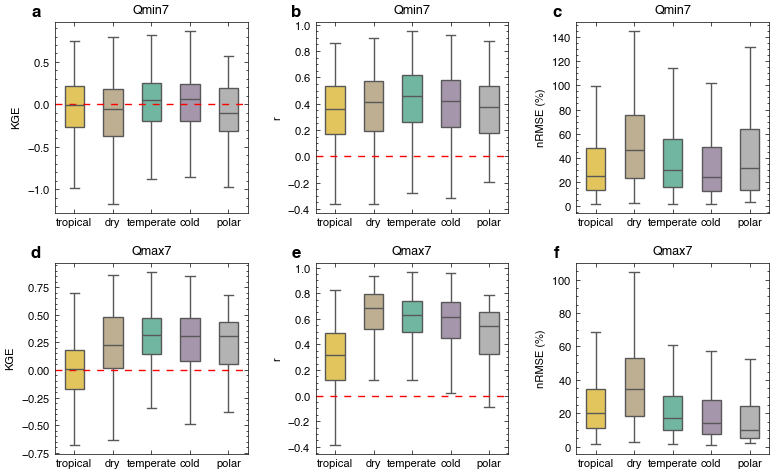

In [5]:
def compute_effsize(expGroup, controlGroup, eftype = 'cohen'):
    n1, n2 = len(expGroup), len(controlGroup)
    MAD1 = 1.4826 * np.median(np.abs(expGroup-np.median(expGroup)))
    MAD2 = 1.4826 * np.median(np.abs(controlGroup-np.median(controlGroup)))
    pooled_std = np.sqrt(((n1 - 1) * MAD1 ** 2 + (n2 - 1) * MAD2 ** 2) / (n1 + n2 - 2))
    if eftype == 'cohen':
        # d = np.mean(expGroup - controlGroup) / np.sqrt((MAD1**2+MAD2**2)/2)
        # d = np.mean(expGroup - controlGroup) / pooled_std
        d = (np.mean(expGroup) - np.mean(controlGroup)) / np.std(expGroup)
    elif eftype == 'glass':
        d = (np.mean(expGroup) - np.mean(controlGroup)) / MAD2
    return d
from scipy import stats

plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
import matplotlib.ticker as ticker
import string
fig, axes = plt.subplots(2, 3, figsize = (8, 5))
x = 0
for i,name in enumerate(['Qmin7','Qmax7']):
    if i == 0:
        df = df_Qmin7.copy()
    else:
        df = df_Qmax7.copy()
    df_sta = df.groupby(['ohdb_id','ohdb_latitude', 'ohdb_longitude','climate_label']).apply(
        lambda x: pd.Series([
            he.kge(x.pred.values, x.Q.values).squeeze()[0],
            np.corrcoef(x.pred.values, x.Q.values)[0,1],
            np.sum((x.pred.values-x.Q.values)**2) / np.sum(x.Q.values**2) * 100
        ], index = ['KGE','r','nRMSE (%)'])
    ).reset_index()
    # for a in ['temperate','cold','dry','polar']:
    #     x = df_sta.r.values
    #     y = df_sta.r.values
    #     effect = compute_effsize(x, y, eftype = 'cohen')
    #     sta, p = stats.ttest_ind(x, y, equal_var = False)
    #     print(name, a, len(x), '{:.4f %4.4f %4.4f %4.4f %4.4f'.format(np.std(x), np.std(y), sta, p, effect))
    for j,name1 in enumerate(['KGE','r','nRMSE (%)']):
        sns.boxplot(data = df_sta, x = 'climate_label', y = name1, ax = axes[i,j], hue = 'climate_label', palette = palette, showfliers = False, width = .5)
        axes[i,j].set_title(name, fontsize = 9)
        axes[i,j].set_xlabel(None)
        axes[i,j].xaxis.set_minor_locator(ticker.NullLocator())
        if name1 in ['KGE','r']:
            axes[i,j].axhline(y = 0, ls = (0,(5,5)), color = 'red', lw = 1)
        axes[i,j].text(-.1, 1.05, string.ascii_letters[x], va = 'center', ha = 'center', weight = 'bold', transform = axes[i,j].transAxes)
        x = x + 1
fig.tight_layout()
fig.savefig(f'../picture/boxplot_cv10_{model}.png', dpi = 600)

### SHAP-based feature importance

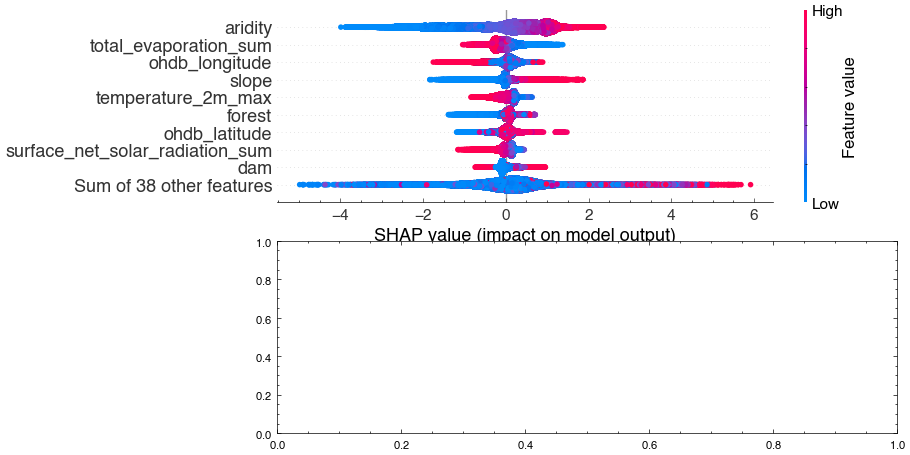

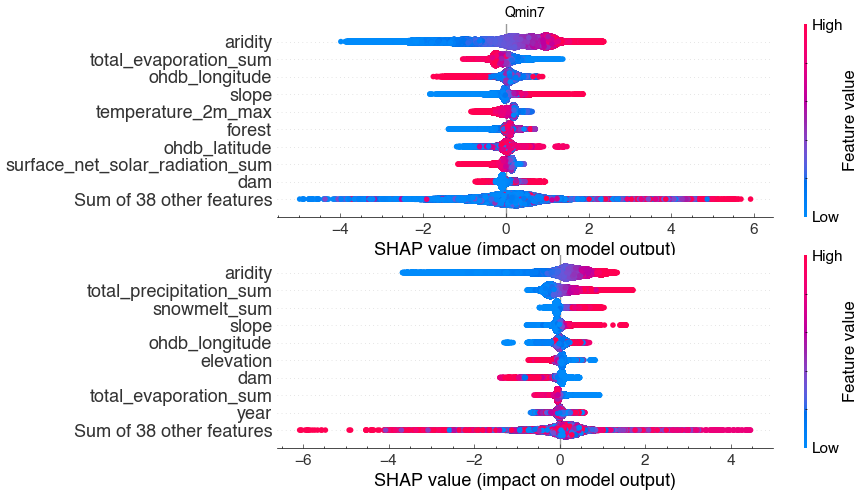

In [12]:
with open(f'../results/shap_object_Qmin7_{model}.pkl', 'rb') as f:
    shap_Qmin7 = pickle.load(f)
with open(f'../results/shap_object_Qmax7_{model}.pkl', 'rb') as f:
    shap_Qmax7= pickle.load(f)

fig, axes = plt.subplots(2, 1, figsize = (8, 10))
plt.sca(axes[0])
shap.plots.beeswarm(shap_Qmin7)
axes[0].set_title('Qmin7', fontsize = 10)

plt.sca(axes[1])
shap.plots.beeswarm(shap_Qmax7)
axes[1].set_title('Qmax7', fontsize = 10)

fig.tight_layout()
fig.savefig(f'../picture/shap_feature_beeswarm_{model}.png', dpi = 600)

In [13]:
df_Qmax7.forest.describe()

count    374854.000000
mean       4370.135673
std        2910.210235
min           0.000000
25%        1721.526976
50%        4012.105865
75%        6960.142788
max        9983.639425
Name: forest, dtype: float64

### correlation between bias and basin attributes

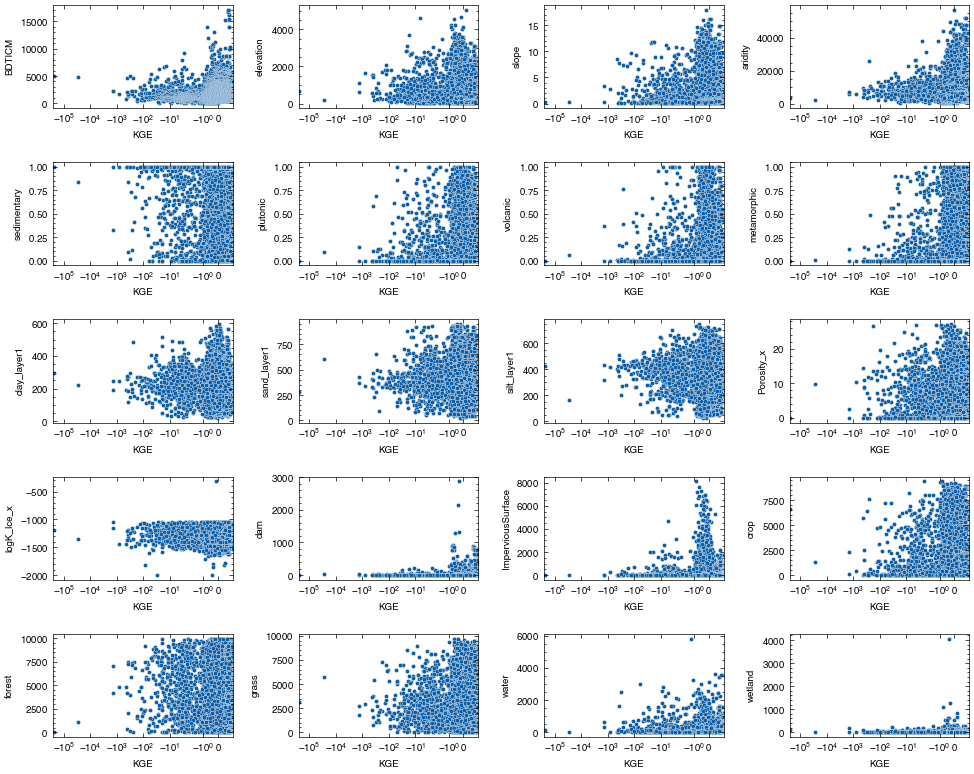

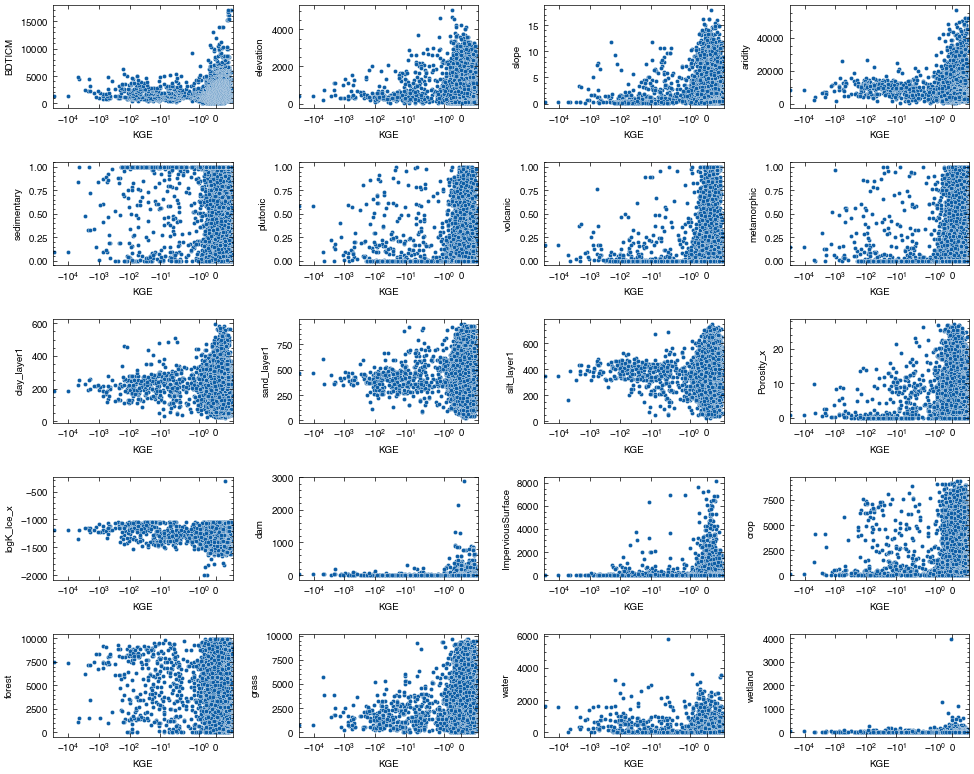

In [5]:
predictors = [  'BDTICM', 'elevation', 'slope', 'aridity', 
                'sedimentary', 'plutonic', 'volcanic', 'metamorphic',
                'clay_layer1', 'sand_layer1', 'silt_layer1', 
                'Porosity_x', 'logK_Ice_x', 'dam', 'ohdb_id'
            ]
lulc = ['ImperviousSurface', 'crop', 'forest', 'grass', 'water', 'wetland']
metric = 'KGE'
for i,name1 in enumerate(['Qmin7','Qmax7']):
    if i == 0:
        df = df_Qmin7.copy()
    else:
        df = df_Qmax7.copy()
    df_sta = df.groupby(predictors).apply(
        lambda x: pd.Series(
            x[lulc].mean(axis=0).values.tolist() + [
            he.kge(x.pred.values, x.Q.values).squeeze()[0],
            np.corrcoef(x.pred.values, x.Q.values)[0,1],
            np.sum((x.pred.values-x.Q.values)**2) / np.sum(x.Q.values**2) * 100
        ], index = lulc + ['KGE','r','nRMSE (%)'])
    ).reset_index()
    fig, axes = plt.subplots(5, 4, figsize = (10, 8))
    for i,name in enumerate(predictors[:-1]+lulc):
        sns.scatterplot(df_sta, x = metric, y = name, ax = axes.ravel()[i])
        axes.ravel()[i].set_xscale('symlog')
        axes.ravel()[i].set_xlim(None, 1)
    fig.tight_layout()
    fig.savefig(f'../picture/scatter_{metric}_basin_attributes_{name1}.png', dpi = 600)
    

### correlation between bias and catchment area

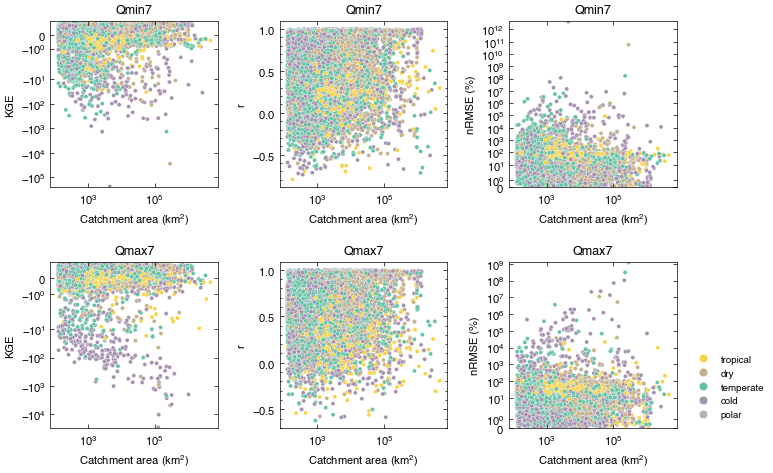

In [10]:
plt.rcParams['axes.labelsize'] = 8
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
fig, axes = plt.subplots(2, 3, figsize = (8, 5))
for i,name in enumerate(['Qmin7','Qmax7']):
    if i == 0:
        df = df_Qmin7.copy()
    else:
        df = df_Qmax7.copy()
    df_sta = df.groupby(['ohdb_id','ohdb_latitude', 'ohdb_longitude','climate_label','gritDarea']).apply(
        lambda x: pd.Series([
            he.kge(x.pred.values, x.Q.values).squeeze()[0],
            np.corrcoef(x.pred.values, x.Q.values)[0,1],
            np.sum((x.pred.values-x.Q.values)**2) / np.sum(x.Q.values**2) * 100
        ], index = ['KGE','r','nRMSE (%)'])
    ).reset_index()
    for j,name1 in enumerate(['KGE','r','nRMSE (%)']):
        if i == 1 and j == 2:
            sns.scatterplot(data = df_sta, x = 'gritDarea', y = name1, ax = axes[i,j], hue = 'climate_label', palette = palette)
            sns.move_legend(axes[i,j], 'lower left', title = None, bbox_to_anchor = (1.05, 0), markerscale = 2)
        else:
            sns.scatterplot(data = df_sta, x = 'gritDarea', y = name1, ax = axes[i,j], hue = 'climate_label', palette = palette, legend = False)
        axes[i,j].set_title(name, fontsize = 9)
        axes[i,j].set_xscale('log')
        if name1 in ['KGE','nRMSE (%)']:
            axes[i,j].set_yscale('symlog')
        if name1 == 'KGE':
            axes[i,j].set_ylim(None, 1)
        if name1 == 'nRMSE (%)':
            axes[i,j].set_ylim(0, None)
        axes[i,j].set_xlabel('Catchment area ($\mathregular{km^2}$)')
fig.tight_layout()
fig.savefig(f'../picture/scatter_darea_metrics_cv10_rf.png', dpi = 600)

### investigate those gauges with poor performance

In [44]:
df = df_Qmax7.copy()
df_sta = df.groupby(['ohdb_id','ohdb_latitude', 'ohdb_longitude','climate_label','gritDarea']).apply(
    lambda x: pd.Series(
        [np.sum((x.pred.values-x.Q.values)**2) / np.sum(x.Q.values**2) * 100], index = ['nRMSE'])
).reset_index()
ohdb_id = df_sta.sort_values('nRMSE',ascending=False).iloc[0,:].ohdb_id
tmp = df.loc[df.ohdb_id==ohdb_id,:].rename(columns={'snow_depth_water_equivalent':'swe','surface_net_solar_radiation_sum':'radiation','total_precipitation_sum':'pr',
                                                    'total_evaporation_sum':'evap','temperature_2m_min':'tmin','temperature_2m_max':'tmax'})
tmp[['swe','snowmelt_sum','radiation','tmax','tmin','evap','pr','Qmax7date','gritDarea','ImperviousSurface', 'crop', 'forest', 'water','Q','ohdb_id']]

,swe,snowmelt_sum,radiation,tmax,tmin,evap,pr,Qmax7date,gritDarea,ImperviousSurface,crop,forest,water,Q,ohdb_id
354924,-7.345365e-25,1.777992e-09,1.469026e+07,299.976135,290.585401,-0.002590,0.008307,1994-02-15,291493.802362,14.231249,1244.082520,1140.232149,46.520295,0.246286,OHDB_004004149
354925,4.107959e-08,6.083232e-08,2.030380e+07,295.856523,284.637055,-0.001750,0.001075,1995-12-23,291493.802362,14.542491,1244.302856,1138.629430,42.180559,0.128000,OHDB_004004149
354926,3.358433e-07,5.304063e-07,1.861097e+07,296.699165,285.079543,-0.002372,0.002149,1996-11-18,291493.802362,14.821769,1244.947590,1145.377661,44.741354,0.135429,OHDB_004004149
354927,-7.345365e-25,5.793995e-10,2.234496e+07,300.696228,288.322043,-0.002364,0.002638,1997-12-19,291493.802362,15.017826,1248.823747,1145.410245,39.172103,0.132000,OHDB_004004149
354928,-7.345365e-25,1.692616e-09,1.168221e+07,299.962623,291.787140,-0.002353,0.007107,2000-02-26,291493.802362,15.743017,1252.798635,1139.435154,34.826878,0.348143,OHDB_004004149
354929,7.831008e-07,7.201766e-07,2.463692e+07,301.186890,288.323479,-0.001918,0.000970,1998-12-27,291493.802362,15.189687,1252.120490,1142.880203,31.352174,0.128571,OHDB_004004149
354930,-7.345365e-25,8.646596e-10,1.842287e+07,303.622241,292.146536,-0.001390,0.000998,1999-02-16,291493.802362,15.358228,1252.976577,1141.999415,36.076347,0.249857,OHDB_004004149
354931,-7.345365e-25,1.842952e-10,2.460551e+07,302.335594,288.193339,-0.001156,0.000287,2001-12-24,291493.802362,16.122221,1250.377538,1146.466073,33.017088,0.092286,OHDB_004004149
354932,-7.279190e-25,2.251752e-10,2.419553e+07,303.500689,289.673076,-0.000850,0.000338,2002-01-20,291493.802362,16.376899,1252.145942,1147.074961,25.137215,0.087714,OHDB_004004149
354933,-7.279190e-25,8.394470e-10,1.931547e+07,302.053672,290.406700,-0.002321,0.004565,2003-12-23,291493.802362,16.539681,1250.894549,1138.097590,21.393431,0.102143,OHDB_004004149


<Axes: xlabel='date'>

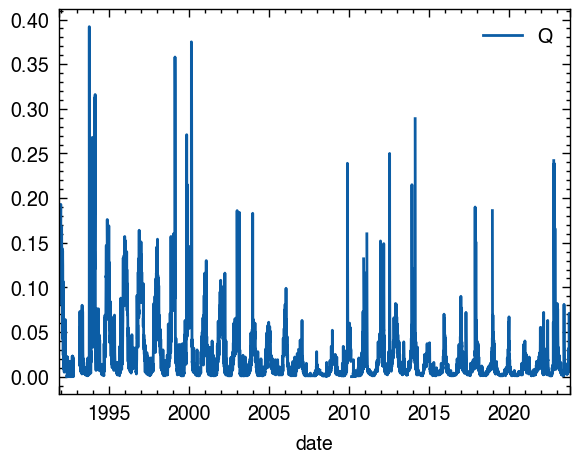

In [48]:
df = pd.read_csv('../data/OHDB_metadata_subset.csv')
# df.loc[df.ohdb_id=='OHDB_004004149',:]
ohdb_id = 'OHDB_004004149'
df = pd.read_csv(os.environ['DATA']+f'/data/OHDB/OHDB_v0.2.3/OHDB_data/discharge/daily/{ohdb_id}.csv')
# df.head()
# def cleanQ(df):
#     # eliminate invalid records
#     df1 = df.loc[df.Q.apply(lambda x: not isinstance(x, str)),:]
#     df2 = df.loc[df.Q.apply(lambda x: isinstance(x, str)),:]
#     try:
#         df2 = df2.loc[df2.Q.str.match('\d+'),:]
#     except:
#         pass
#     df = pd.concat([df1, df2])
#     df['Q'] = df.Q.astype(np.float32)
#     return df
# df = cleanQ(df)
df['date'] = pd.to_datetime(df.date)
df = df.set_index('date')
plt.rcParams['figure.dpi'] = 200
df.plot()


In [ ]:
from pyogrio import read_dataframe
def get_upstream(global_id, G):
    nodes = nx.edge_dfs(G, global_id, orientation='reverse')
    if len(list(nodes)) == 0:
        x = [global_id]
    else:
        y = list(list(zip(*(nx.edge_dfs(G, global_id, orientation='reverse'))))[0])
        x = y+[global_id] 
    return x
df_all = []
for fname in glob.glob('../basin_boundary/GRIT_full_catchment_*_EPSG8857_simplify_final_125km2_subset.gpkg'):
    gdf = read_dataframe(fname, read_geometry = False)
    df_all.append(gdf[['ohdb_id','reach_id']])
df_all = pd.concat(df_all)
df_all['reach_id'] = df_all.reach_id.astype(np.int64)
df_all1 = []
for fname in glob.glob('../../data/GRIT/segments/GRITv05_reaches_*_EPSG8857.gpkg'):
    gdf = read_dataframe(fname, read_geometry = False)
    tmp = df_all.merge(gdf[['global_id','grwl_width_median']].rename(columns={'global_id':'reach_id'}), on = 'reach_id')
    df_all1.append(tmp)
df_all1 = pd.concat(df_all1)
df_all1.head()



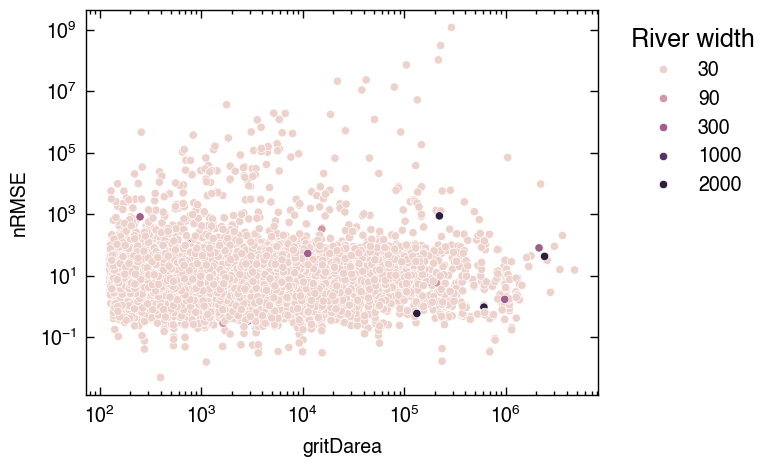

In [64]:
df = pd.read_csv('../data/basin_attributes.csv')
df = df_sta.merge(df[['ohdb_id','grwl_width_median']], on = 'ohdb_id')
df['width'] = 30
df.loc[(df.grwl_width_median>30)&(df.grwl_width_median<=90),'width'] = 90
df.loc[(df.grwl_width_median>90)&(df.grwl_width_median<=300),'width'] = 300
df.loc[(df.grwl_width_median>300)&(df.grwl_width_median<=1000),'width'] = 1000
df.loc[(df.grwl_width_median>1000),'width'] = 2000
fig, ax = plt.subplots()
sns.scatterplot(df, x = 'gritDarea', y = 'nRMSE', hue = 'width', ax = ax, hue_norm = mpl.colors.LogNorm())
sns.move_legend(ax, 'upper left', title = 'River width', title_fontsize = 9, bbox_to_anchor = (1.03, 1))
ax.set_xscale('log')
ax.set_yscale('log')

In [62]:
df.grwl_width_median.describe()

count    10717.000000
mean        67.921865
std       1105.659724
min         30.000000
25%         30.000000
50%         30.000000
75%         30.000000
max      64897.300000
Name: grwl_width_median, dtype: float64